<h1>
<hr style=" border:none; height:3px;">
<center>Computer Vision - Photo to Chess Board Project</center>
<hr style=" border:none; height:3px;">
</h1>

<center><img src='https://netacad.centralesupelec.fr/img/cs.jpg' width=200></center>

<h4><center>Louis LHOTTE | Paul-Alexandre MARENGHI</center></h4>

![Pipeline](./data/Slide/pipeline.jpg)

# 0 - Import

https://github.com/shainisan/real-life-chess-vision
<div class='alert alert-block alert-success'> <strong>PLAN</strong> <br>
- Read Img<br>
- Detect Corners<br>
- Perspective Transformation + calculate square positions<br>
- Detect pieces on board<br>
- TADA!<br>
</div>


In [53]:
from matplotlib.pyplot import figure
import matplotlib.image as image
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
from PIL import Image
import cv2
from shapely.geometry import Polygon, box

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
import torch
from torchvision import transforms
from transformers import AutoImageProcessor, Dinov2Model

# I - Detect Corners

## I.1 - Detection of corner

In [54]:
def segment_chessboard(image_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # You might need to tweak these ranges depending on the board color
    lower_color = np.array([0, 30, 30])
    upper_color = np.array([180, 255, 200])

    mask = cv2.inRange(hsv, lower_color, upper_color)
    result = cv2.bitwise_and(image, image, mask=mask)

    return result, mask

def show_image_rgb(img, title="Image"):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [55]:
def reorder_points(pts):
    """
    Sort corners into order: 
        [top-left, top-right, bottom-right, bottom-left]
    """
    pts = pts.astype(np.float32)
    s = pts.sum(axis=1)
    diff = np.diff(pts, axis=1)

    ordered = np.zeros((4, 2), dtype=np.float32)
    ordered[0] = pts[np.argmin(s)]      # top-left
    ordered[2] = pts[np.argmax(s)]      # bottom-right
    ordered[1] = pts[np.argmin(diff)]   # top-right
    ordered[3] = pts[np.argmax(diff)]   # bottom-left
    return ordered

def detect_corners(img):
    """
    Inspired by Sudoku detection approach:
    1) Grayscale, blur
    2) Adaptive threshold
    3) Morphological closing
    4) Find largest contour that isn't too small or too large
    5) Approximate to 4 corners -> return
    6) Otherwise fallback to rotated bounding box
    """
    # 1) Grayscale + blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5,5), 0)
    
    # 2) Adaptive threshold (makes the board region bright/white)
    #    We invert so that the board is white on black background
    thresh = cv2.adaptiveThreshold(
        gray_blur, 
        255, 
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY, 
        11,    # blockSize
        2      # C constant subtracted from mean
    )
    # Invert: the board area becomes white, background black
    thresh = cv2.bitwise_not(thresh)

    # 3) Morphological closing to fill gaps in the board edges
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # 4) Find contours in the closed image
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    # Sort by descending area
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    img_area = img.shape[0] * img.shape[1]

    # Attempt to find a 4-corner polygon
    for cnt in contours:
        area = cv2.contourArea(cnt)
        # Filter out tiny or massive (entire image) contours
        if area < 0.02 * img_area or area > 0.9 * img_area:
            continue

        # Approximate the contour
        peri = cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, 0.02 * peri, True)
        
        # If we get 4 corners, reorder and return
        if len(approx) == 4:
            corners = approx.reshape(4, 2)
            return reorder_points(corners)

    # 5) Fallback: if no 4-corner polygon found, 
    #    use minAreaRect on the largest plausible contour
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < 0.02 * img_area or area > 0.9 * img_area:
            continue
        rect = cv2.minAreaRect(cnt)   # ((cx,cy),(w,h),angle)
        box = cv2.boxPoints(rect)     # 4 corner points
        return reorder_points(box)

    return None

## I.2 - Perspective

In [56]:
def warp_perspective(image, corners):
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect
    
    image = np.array(image)

    rect = order_points(np.array(corners, dtype="float32"))
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = int(max(widthA, widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = int(max(heightA, heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped


def divide_board_into_grid(image, grid_size=8):
    import numpy as np
    h, w = image.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size
    grid = []
    for i in range(grid_size):
        row = []
        for j in range(grid_size):
            y1, y2 = i * cell_h, (i + 1) * cell_h
            x1, x2 = j * cell_w, (j + 1) * cell_w
            cell = image[y1:y2, x1:x2]
            row.append(cell)
        grid.append(row)
    return grid


## I.3 - Chessboard cells extraction

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def crop_inner_board(image, crop_ratio=0.03):
    h, w = image.shape[:2]
    offset_h = int(h * crop_ratio)
    offset_w = int(w * crop_ratio)
    return image[offset_h:h - offset_h, offset_w:w - offset_w]

def extract_labeled_cells(image, grid_size=8):
    h, w = image.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size
    cells = []
    labels = []

    files = 'ABCDEFGH'
    ranks = '87654321'

    for i in range(grid_size):
        for j in range(grid_size):
            y1 = i * cell_h
            y2 = (i + 1) * cell_h
            x1 = j * cell_w
            x2 = (j + 1) * cell_w
            cells.append(image[y1:y2, x1:x2])
            labels.append(f"{files[j]}{ranks[i]}")
    return cells, labels

def show_cells(cells, labels, grid_size=8):
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for i in range(grid_size):
        for j in range(grid_size):
            idx = i * grid_size + j
            cell_rgb = cv2.cvtColor(cells[idx], cv2.COLOR_BGR2RGB)
            axs[i, j].imshow(cell_rgb)
            axs[i, j].axis('off')
            axs[i, j].set_title(labels[idx], fontsize=8)
    plt.tight_layout()
    plt.show()

## I.4 - Piece detection

In [58]:
# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Load DINOv2 Model and Processor ---
model_id = "facebook/dinov2-small"
processor = AutoImageProcessor.from_pretrained(model_id)
model = Dinov2Model.from_pretrained(model_id).to(device)
model.eval()

# --- Preprocess image for DINOv2 ---
def preprocess(image):
    inputs = processor(images=image, return_tensors="pt")
    return inputs['pixel_values'].to(device)

# --- Extract feature embedding ---
def get_embedding(image):
    with torch.no_grad():
        pixel_values = preprocess(image)
        outputs = model(pixel_values)
        embedding = outputs.last_hidden_state.mean(dim=1)  # mean pooling
        return embedding.squeeze()

# --- Load reference piece embeddings ---
def load_reference_embeddings(asset_folder):
    references = {}
    for label in os.listdir(asset_folder):
        label_path = os.path.join(asset_folder, label)
        if os.path.isdir(label_path):
            embeddings = []
            for file in os.listdir(label_path):
                if file.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_path = os.path.join(label_path, file)
                    img = Image.open(img_path).convert("RGB")
                    emb = get_embedding(img)
                    embeddings.append(emb)
            if embeddings:
                # Average embeddings for this class
                stacked = torch.stack(embeddings)
                references[label] = stacked.mean(dim=0)
    return references

# --- Cosine similarity ---
def cosine_similarity(a, b):
    return torch.nn.functional.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

# --- Compare each square to references ---
def classify_board_cells(cell_images, reference_embeddings):
    results = []
    for img in cell_images:
        emb = get_embedding(img)
        similarities = {
            label: cosine_similarity(emb, ref_emb) for label, ref_emb in reference_embeddings.items()
        }
        best_match = max(similarities, key=similarities.get)
        results.append(best_match)
    return results

# --- Chess notation helper ---
def get_notation(row, col):
    return f"{chr(ord('A') + col)}{8 - row}"

## I.5 - Chessboard visualisation

In [59]:
def remove_checkerboard_background(img):
    img = img.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        r, g, b, a = item
        if r > 200 and g > 200 and b > 200:
            newData.append((255, 255, 255, 0))
        else:
            newData.append((r, g, b, a))
    img.putdata(newData)
    return img

def visualize_board(classified_labels):
    board = np.array(classified_labels).reshape(8, 8)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks(range(8))
    ax.set_yticks(range(8))
    ax.set_xticklabels([chr(i) for i in range(65, 73)])
    ax.set_yticklabels(list(reversed(range(1, 9))))
    ax.imshow([[1 if (i + j) % 2 == 0 else 0.7 for j in range(8)] for i in range(8)],
              cmap='Blues', extent=(0, 8, 0, 8))

    for i in range(8):
        for j in range(8):
            piece = board[i][j]
            if piece not in ["white_cell", "black_cell"]:
                image_path = os.path.join("./2d_assets", piece, f"{piece}.png")
                if os.path.exists(image_path):
                    img = Image.open(image_path)
                    img = remove_checkerboard_background(img)
                    img = img.resize((40, 40), resample=Image.Resampling.LANCZOS)
                    im = OffsetImage(img, zoom=1, interpolation='none')
                    ab = AnnotationBbox(im, (j + 0.5, i + 0.5), frameon=False)
                    ax.add_artist(ab)

    plt.grid(False)
    plt.title("Detected Chess Board Pieces")
    plt.xlim(0, 8)
    plt.ylim(0, 8)
    plt.gca().invert_yaxis()
    plt.show()


# II - Detection

(1088, 1536, 3)


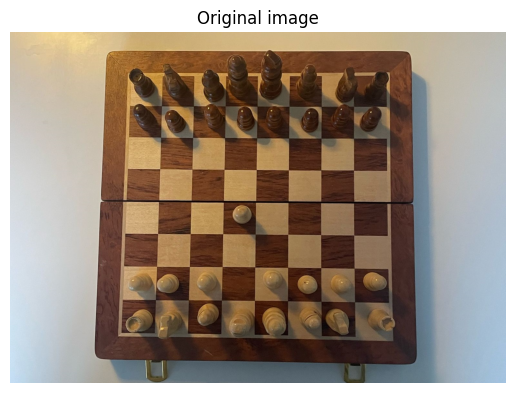

In [89]:
image = 'data/chessboard/chessboard_cleaned.jpg'
img = cv2.imread(image)
print(img.shape)
show_image_rgb(img, "Original image")

[[ 286.   75.]
 [1242.   56.]
 [1262. 1024.]
 [ 257.  999.]]


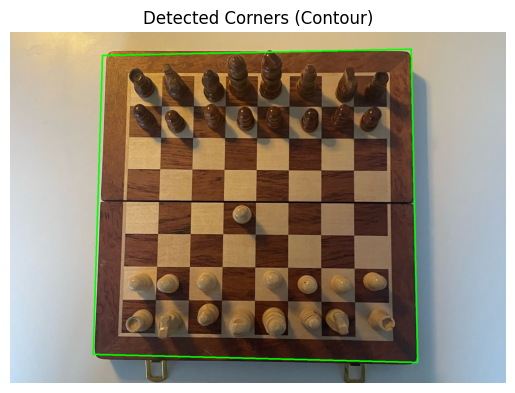

In [90]:
corners = detect_corners(img)
print(corners)
cv2.polylines(img, [np.int32(corners)], isClosed=True, color=(0, 255, 0), thickness=4)
show_image_rgb(img, "Detected Corners (Contour)")

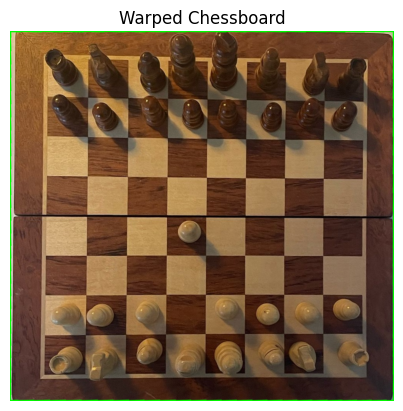

In [91]:
warped = warp_perspective(img, corners)
show_image_rgb(warped, "Warped Chessboard")

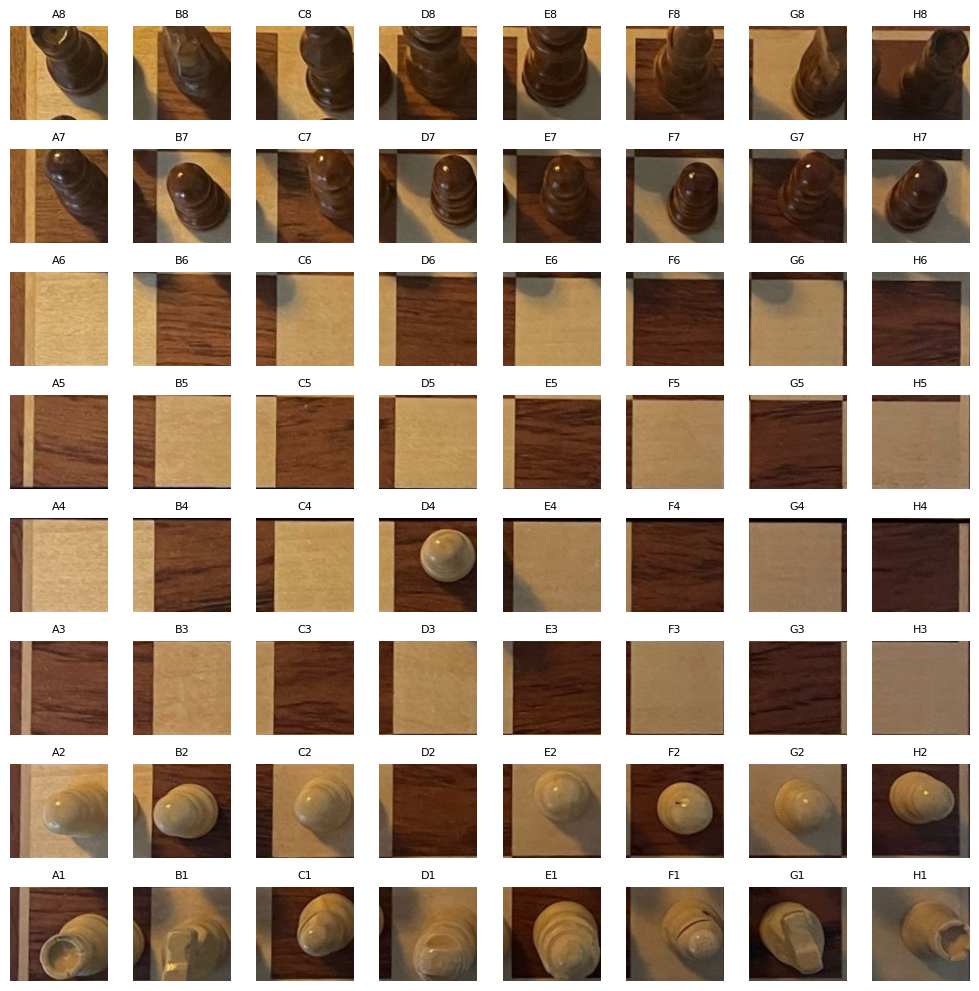

In [92]:
cropped = crop_inner_board(warped, crop_ratio=0.07)
cells, labels = extract_labeled_cells(cropped)
show_cells(cells, labels)

In [86]:
# image = 'data/chessboard/chessboard_15.jpg'
# img = cv2.imread(image)
# img_rgb = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
# cv2.imwrite(img=img_rgb, filename='chess_gray.jpg')
# plt.imshow(img_rgb)
# plt.axis("off")
# plt.show()

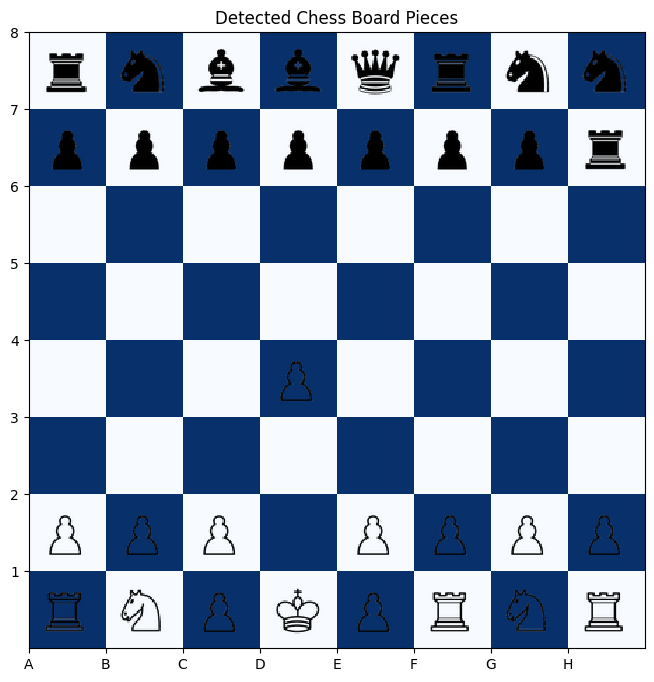

In [93]:
asset_folder = "./assets"
reference_embeddings = load_reference_embeddings(asset_folder)
classified_labels = classify_board_cells(cells, reference_embeddings)
visualize_board(classified_labels)